# Data preparation for GLMs using A&E attendance data from 2018-2022.

In this notebook we will look through generating the relevant data from the raw files, in order to run Poisson generalised linear models (GLMs).

For this we will need the following packages
- pandas
- numpy
- matplotlib
- seaborn
- scipy
- statsmodels

We can check and download any packages required using the below.

In [1]:
!pip install pandas numpy matplotlib seaborn scipy statsmodels

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

## 1. Load in data files and manipulate.

In [3]:
DemographicData = pd.read_csv('/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/data/AdaptedData/monthlyae_demographics_202406.csv')
TimeData = pd.read_csv('/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/teoh/Rawdata/monthlyae_when_202406.csv')

In [4]:
DemographicDataReduced = DemographicData[['Month', 'HBT', 'DepartmentType', 'Age', 'Sex', 'Deprivation', 'NumberOfAttendances']]
DemographicDataReducedDates = DemographicDataReduced[DemographicDataReduced['Month'] >= 201801]
DemographicDataReducedDates = DemographicDataReduced[DemographicDataReduced['Month'] < 202301]
DemographicDataReducedDates = DemographicDataReducedDates.assign(
    Year = DemographicDataReduced['Month'] // 100,
    MonthNumber = DemographicDataReduced['Month'] % 100)

DemographicDataReducedDates['Age'] = DemographicDataReducedDates['Age'].fillna('UnknownAge')
DemographicDataReducedDates['Sex'] = DemographicDataReducedDates['Sex'].fillna('UnknownSex')
DemographicDataReducedDates['DepartmentType'] = DemographicDataReducedDates['DepartmentType'].fillna('UnknownDepartmentType')
DemographicDataReducedDates['Deprivation'] = DemographicDataReducedDates['Deprivation'].fillna('Unknown')
DemographicDataReducedDates['HBT'] = DemographicDataReducedDates['HBT'].fillna('UnknownHB')

DemographicDataReducedDates.rename(columns={'HBT': 'HealthBoard'}, inplace=True)

DemographicDataReducedDates['Deprivation'] = DemographicDataReducedDates['Deprivation'].replace({
    1.0: 'SIMD1', 
    2.0: 'SIMD2', 
    3.0: 'SIMD3', 
    4.0: 'SIMD4', 
    5.0: 'SIMD5', 
    'Unknown': 'UnknownSIMD'
})
DemographicDataReducedDates['DepartmentType'] = DemographicDataReducedDates['DepartmentType'].replace({
    'Emergency Department': 'ED', 
    'Minor Injury Unit or Other': 'MIU'
})

In [5]:
TimeDataReduced = TimeData[['Month', 'HBT', 'DepartmentType', 'Day', 'Week', 'Hour', 'NumberOfAttendances']]
TimeDataReducedDates = TimeDataReduced[TimeDataReduced['Month'] >= 201801]
TimeDataReducedDates = TimeDataReduced[TimeDataReduced['Month'] < 202301]
TimeDataReducedDates = TimeDataReducedDates.assign(
    Year = TimeDataReducedDates['Month'] // 100,
    MonthNumber = TimeDataReducedDates['Month'] % 100)
TimeDataReducedDates.rename(columns={'HBT': 'HealthBoard'}, inplace=True)
TimeDataReducedDates['DepartmentType'] = TimeDataReducedDates['DepartmentType'].replace({
    'Emergency Department': 'ED', 
    'Minor Injury Unit or Other': 'MIU'
})

## 2. Create data summaries.

### Total Attendances

In [6]:
TotalAttendances_PerMonth = (
    DemographicDataReducedDates[['Month', 'NumberOfAttendances']]
    .groupby('Month')
    .agg({'NumberOfAttendances': 'sum'})
    .reset_index()
)

TotalAttendances_PerMonth.rename(columns={'NumberOfAttendances': 'TotalAttendances'}, inplace=True)

TotalAttendances_PerMonth['DateFormatted'] = pd.to_datetime(TotalAttendances_PerMonth['Month'].astype(str), format='%Y%m')

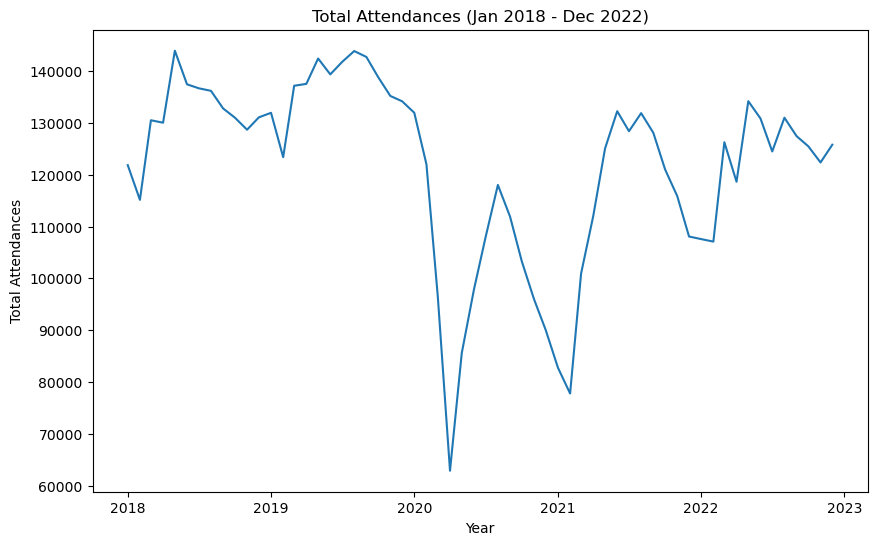

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(TotalAttendances_PerMonth['DateFormatted'], TotalAttendances_PerMonth['TotalAttendances'])
plt.title('Total Attendances (Jan 2018 - Dec 2022)')
plt.xlabel('Year')
plt.ylabel('Total Attendances')
plt.savefig("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/coldnall/results/COVID_AttendanceChecks/TotalAttendances.png")
plt.show()

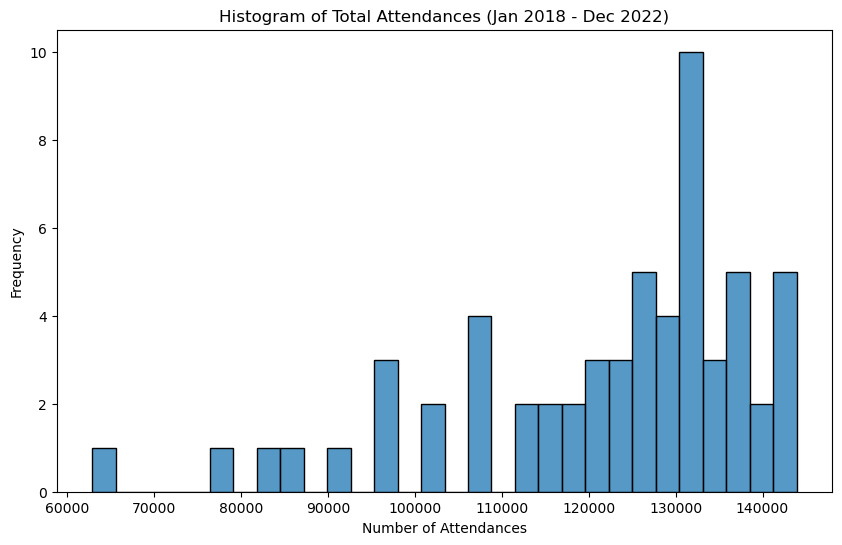

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(TotalAttendances_PerMonth['TotalAttendances'], bins=30, kde=False)
plt.title('Histogram of Total Attendances (Jan 2018 - Dec 2022)')
plt.xlabel('Number of Attendances')
plt.ylabel('Frequency')
plt.savefig("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/coldnall/results/COVID_AttendanceChecks/Histogram_TotalAttendances.png")
plt.show()

<Figure size 1000x600 with 0 Axes>

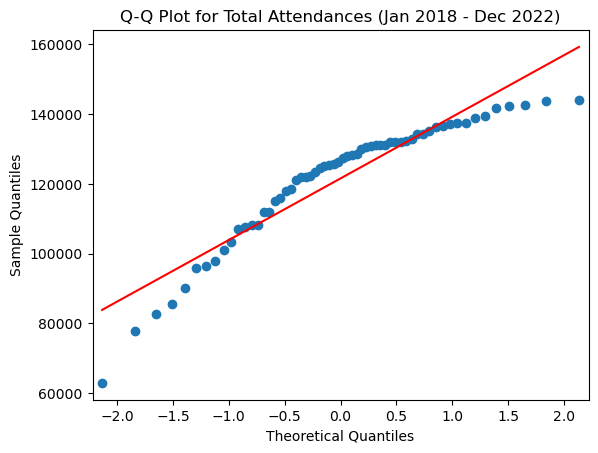

In [9]:
plt.figure(figsize=(10, 6))
sm.qqplot(TotalAttendances_PerMonth['TotalAttendances'], line='s')
plt.title('Q-Q Plot for Total Attendances (Jan 2018 - Dec 2022)')
plt.savefig("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/coldnall/results/COVID_AttendanceChecks/QQplot_TotalAttendances.png")  # Save the plot
plt.show()

In [10]:
attendance_data = TotalAttendances_PerMonth['TotalAttendances']
ks_statistic, p_value = stats.kstest(attendance_data, 'norm', 
                                     args=(attendance_data.mean(), attendance_data.std()))
result_statement = f"Kolmogorov-Smirnov test result: D = {ks_statistic:.5f}, p-value = {p_value:.5f}\n"
if p_value < 0.05:
    interpretation = "Reject the null hypothesis: Data does not follow a normal distribution."
else:
    interpretation = "Fail to reject the null hypothesis: Data may follow a normal distribution."
result_statement += interpretation
print(result_statement)
with open('/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/coldnall/results/COVID_AttendanceChecks/KS_Test_Results.txt', 'w') as f:
    f.write(result_statement)

Kolmogorov-Smirnov test result: D = 0.15665, p-value = 0.09424
Fail to reject the null hypothesis: Data may follow a normal distribution.


# 3. Total Attendances per Variable

In [11]:
def TotalAttendanceCalculator(DemographicDataReducedDates, VariableName):
    TotalAttendance = (
        DemographicDataReducedDates[['Month', VariableName, 'NumberOfAttendances']]
        .groupby(['Month', VariableName])
        .agg({'NumberOfAttendances': 'sum'})
        .reset_index()
    )
    return TotalAttendance

In [12]:
TotalAttendances_PerMonthAgeGroup = TotalAttendanceCalculator(DemographicDataReducedDates, 'Age')
TotalAttendances_PerMonthSexGroup = TotalAttendanceCalculator(DemographicDataReducedDates, 'Sex')
TotalAttendances_PerMonthDeprivationGroup = TotalAttendanceCalculator(DemographicDataReducedDates, 'Deprivation')
TotalAttendances_PerMonthDepartmentTypeGroup = TotalAttendanceCalculator(DemographicDataReducedDates, 'DepartmentType')
TotalAttendances_PerMonthHealthBoardGroup = TotalAttendanceCalculator(DemographicDataReducedDates, 'HealthBoard')
TotalAttendances_PerMonthDay = TotalAttendanceCalculator(TimeDataReducedDates, 'Day')

## 4. Calculating proportions for the data.

In [13]:
def ProportionCalculator(TotalAttendances_PerMonth, TotalAttendances_Variable, VariableName):
    MergedDF = pd.merge(TotalAttendances_PerMonth, TotalAttendances_Variable, on='Month')
    MergedDF[f'{VariableName}AttendanceProportion'] = (MergedDF['NumberOfAttendances'] / MergedDF['TotalAttendances'])
    MergedDF = MergedDF[['Month', f'{VariableName}', f'{VariableName}AttendanceProportion']]
    return MergedDF

In [14]:
TotalAttendances_PerMonthAgeGroup_WithTotals = ProportionCalculator(TotalAttendances_PerMonth, TotalAttendances_PerMonthAgeGroup, 'Age')
TotalAttendances_PerMonthSexGroup_WithTotals = ProportionCalculator(TotalAttendances_PerMonth, TotalAttendances_PerMonthSexGroup, 'Sex')
TotalAttendances_PerMonthDeprivationGroup_WithTotals = ProportionCalculator(TotalAttendances_PerMonth, TotalAttendances_PerMonthDeprivationGroup, 'Deprivation')
TotalAttendances_PerMonthDepartmentTypeGroup_WithTotals = ProportionCalculator(TotalAttendances_PerMonth, TotalAttendances_PerMonthDepartmentTypeGroup, 'DepartmentType')
TotalAttendances_PerMonthHealthBoardGroup_WithTotals = ProportionCalculator(TotalAttendances_PerMonth, TotalAttendances_PerMonthHealthBoardGroup, 'HealthBoard')
TotalAttendances_PerMonthDay_WithTotals = ProportionCalculator(TotalAttendances_PerMonth, TotalAttendances_PerMonthDay, 'Day')

# 5. Merging proportional data

In [15]:
ProportionalData = pd.merge(TotalAttendances_PerMonthAgeGroup_WithTotals, 
                            TotalAttendances_PerMonthSexGroup_WithTotals, 
                            on='Month')

ProportionalData = pd.merge(ProportionalData, 
                            TotalAttendances_PerMonthDeprivationGroup_WithTotals, 
                            on='Month')

ProportionalData = pd.merge(ProportionalData, 
                            TotalAttendances_PerMonthDepartmentTypeGroup_WithTotals, 
                            on='Month')

ProportionalData = pd.merge(ProportionalData, 
                            TotalAttendances_PerMonthHealthBoardGroup_WithTotals, 
                            on='Month')

ProportionalData = pd.merge(ProportionalData, 
                            TotalAttendances_PerMonth, 
                            on='Month')

ProportionalData = pd.merge(ProportionalData,
                            TotalAttendances_PerMonthDay_WithTotals,
                            on='Month')

ProportionalData

,Month,Age,AgeAttendanceProportion,Sex,SexAttendanceProportion,Deprivation,DeprivationAttendanceProportion,DepartmentType,DepartmentTypeAttendanceProportion,HealthBoard,HealthBoardAttendanceProportion,TotalAttendances,DateFormatted,Day,DayAttendanceProportion
0,201801,18-24,0.092904,Female,0.489828,SIMD1,0.276111,ED,0.871054,S08000015,0.067801,121857,2018-01-01,Friday,0.123661
1,201801,18-24,0.092904,Female,0.489828,SIMD1,0.276111,ED,0.871054,S08000015,0.067801,121857,2018-01-01,Monday,0.178611
2,201801,18-24,0.092904,Female,0.489828,SIMD1,0.276111,ED,0.871054,S08000015,0.067801,121857,2018-01-01,Saturday,0.120469
3,201801,18-24,0.092904,Female,0.489828,SIMD1,0.276111,ED,0.871054,S08000015,0.067801,121857,2018-01-01,Sunday,0.126337
4,201801,18-24,0.092904,Female,0.489828,SIMD1,0.276111,ED,0.871054,S08000015,0.067801,121857,2018-01-01,Thursday,0.125204
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1481755,202212,UnknownAge,0.017313,UnknownSex,0.017313,UnknownSIMD,0.058093,MIU,0.097290,S08000032,0.126925,125799,2022-12-01,Saturday,0.152672
1481756,202212,UnknownAge,0.017313,UnknownSex,0.017313,UnknownSIMD,0.058093,MIU,0.097290,S08000032,0.126925,125799,2022-12-01,Sunday,0.131639
1481757,202212,UnknownAge,0.017313,UnknownSex,0.017313,UnknownSIMD,0.058093,MIU,0.097290,S08000032,0.126925,125799,2022-12-01,Thursday,0.154469
1481758,202212,UnknownAge,0.017313,UnknownSex,0.017313,UnknownSIMD,0.058093,MIU,0.097290,S08000032,0.126925,125799,2022-12-01,Tuesday,0.136575


# 6. Inserting COVID indicators.

In [16]:
conditions = [
    (ProportionalData['Month'].between(201801, 202003)),
    (ProportionalData['Month'].between(202004, 202005)),
    (ProportionalData['Month'].between(202006, 202009)),
    (ProportionalData['Month'].between(202010, 202012)),
    (ProportionalData['Month'].between(202101, 202104)),
    (ProportionalData['Month'].between(202105, 202107)),
    (ProportionalData['Month'].between(202108, 202212))
]

values = [4, 1, 3, 2, 1, 3, 4]
ProportionalData['CovidPeriod'] = np.select(conditions, values)
ProportionalData['CovidPeriod'] = ProportionalData['CovidPeriod'].astype('category')

In [38]:
ProportionalData.to_csv("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/data/ProcessedData/AE_Prop_GLM_Data.csv", index=False)

# 7. Pivoting the data.

In [20]:
proportion_columns = {
    'Sex': 'SexAttendanceProportion',
    'Age': 'AgeAttendanceProportion',
    'Deprivation': 'DeprivationAttendanceProportion',
    'DepartmentType': 'DepartmentTypeAttendanceProportion',
    'HealthBoard': 'HealthBoardAttendanceProportion',
    'Day': 'DayAttendanceProportion'
}

base_columns = ['Month', 'TotalAttendances', 'CovidPeriod', 'DateFormatted']
PivotData = ProportionalData[base_columns].drop_duplicates()

for category, proportion_column in proportion_columns.items():
    pivot_df = ProportionalData.pivot_table(
        index=base_columns,
        columns=category,
        values=proportion_column
    ).reset_index()
    pivot_df.columns = ['_'.join([str(i) for i in col]).strip() if isinstance(col, tuple) else col for col in pivot_df.columns]
    PivotData = PivotData.merge(pivot_df, on=base_columns, how='left')

PivotData.to_csv("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/data/ProcessedData/AE_Prop_Pivot_GLM_Data.csv", index=False)

# 8. Monthly-based seasonal trends

In order to include the time-based elements, we add into the data two items.

- Sinisoidal trends. These aim to incorporate any seasonal elements across the 12 months that occur.
- Linear day based time trend. This aims to see overall across time if there is a linear decrease or increase aiming to capture trends not otherwise in the data.

In [21]:
PivotData = PivotData.assign(
    Year = PivotData['Month'] // 100,
    MonthNumber = PivotData['Month'] % 100)

PivotData['sin_month'] = np.sin(2 * np.pi * PivotData['MonthNumber'] / 12)
PivotData['cos_month'] = np.cos(2 * np.pi * PivotData['MonthNumber'] / 12)

PivotData['Month'] = PivotData['Month'].astype(str)
PivotData['Date'] = pd.to_datetime(PivotData['Month'], format='%Y%m')
reference_date = pd.to_datetime('2018-01-01')
PivotData['Time'] = (PivotData['Date'] - reference_date).dt.days

In [22]:
PivotData.to_csv("/Users/chrisoldnall/Library/Mobile Documents/com~apple~CloudDocs/PhD/Masters Supervision/1. Hui Pheng Teoh/GitHub/Usher_AandE_Masters/Usher_AandE_Masters/data/ProcessedData/AE_Prop_Time_Pivot_GLM_Data.csv", index=False)